<a href="https://colab.research.google.com/github/dahlp94/recommender-systems/blob/main/DeepRecommender/data_loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ml-latest-small.zip to ml-latest-small.zip


In [2]:
!unzip ml-latest-small.zip -d ml-latest-small

Archive:  ml-latest-small.zip
   creating: ml-latest-small/ml-latest-small/
  inflating: ml-latest-small/ml-latest-small/links.csv  
  inflating: ml-latest-small/ml-latest-small/tags.csv  
  inflating: ml-latest-small/ml-latest-small/ratings.csv  
  inflating: ml-latest-small/ml-latest-small/README.txt  
  inflating: ml-latest-small/ml-latest-small/movies.csv  


In [6]:
ratings_df = pd.read_csv("/content/ml-latest-small/ml-latest-small/ratings.csv")
movies_df = pd.read_csv("/content/ml-latest-small/ml-latest-small/movies.csv")

In [8]:
ratings_df.sample(3)

,userId,movieId,rating,timestamp
79964,500,2289,3.0,1005527309
92107,596,122906,5.0,1535708624
41532,282,1961,4.5,1378490589


In [9]:
movies_df.sample(3)

,movieId,title,genres
132,159,Clockers (1995),Crime|Drama|Mystery
5476,26236,"White Sun of the Desert, The (Beloe solntse pu...",Action|Adventure|Comedy|Drama|Romance|War
2403,3189,My Dog Skip (1999),Children|Drama


In [7]:
# let us merge data on movie id
df_combined = pd.merge(ratings_df, movies_df, on = 'movieId')

In [10]:
df_combined.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


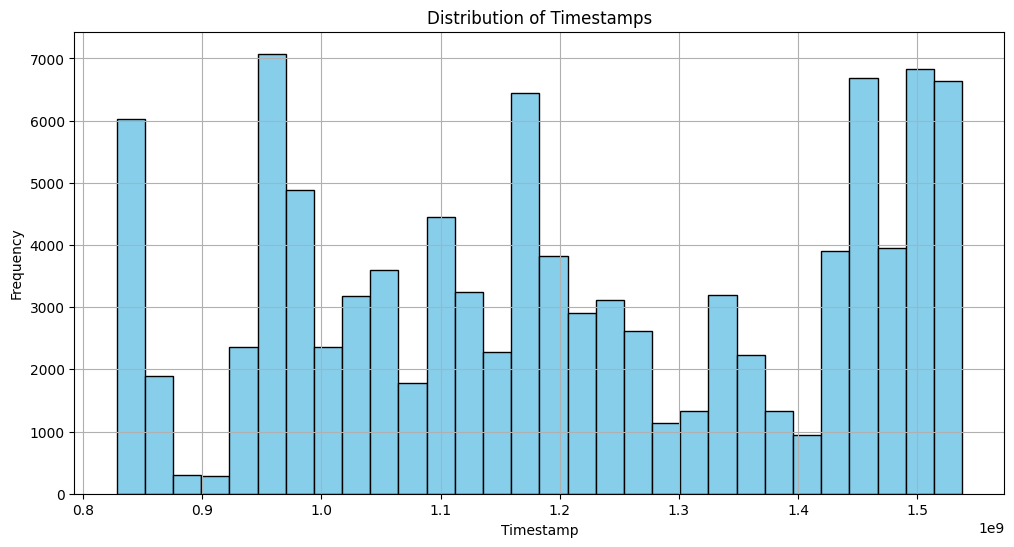

In [11]:
# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(ratings_df['timestamp'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Timestamps')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

In [13]:
# timestamp threshold
ts = ratings_df['timestamp'].quantile(0.98)
ts

1529334436.3

*   Time-Based Training: Train the model on past data and test it on future data to simulate real-world predictions.

*   Prevent Future Information: Avoid including future information in the training data to get accurate performance estimates.



In [14]:
# Split the DataFrame based on the timestamp condition
train_ratings = ratings_df[ratings_df['timestamp'] <= ts][['userId', 'movieId', 'rating']]
validation_ratings = ratings_df[['userId', 'movieId', 'rating']]

# Print progress
print(f"Processed {len(ratings_df)} rows")

Processed 100836 rows


In [15]:
train_ratings = train_ratings.reset_index(drop=True)
validation_ratings = validation_ratings.reset_index(drop=True)

In [16]:
print(len(train_ratings))
print(len(validation_ratings))

98819
100836


In [17]:
# Get unique user IDs from the training set
train_users = train_ratings['userId'].unique()

# Find users not present in the training set
users_not_in_train_set = [user for user in range(1, 611) if user not in train_users]

In [18]:
users_not_in_train_set

[25, 77, 98, 184, 248, 258, 272, 296, 331, 338, 362, 514, 556, 586, 596]

In [19]:
# Remove users in validation set who are not present in the training set
validation_ratings = validation_ratings[validation_ratings['userId'].isin(train_users)]

# Reset index and get unique user IDs
validation_ratings.reset_index(drop=True, inplace=True)
unique_users = validation_ratings['userId'].unique()

In [20]:
unique_users

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 18

In [21]:
# Get unique movie IDs from validation and training sets
validation_movies = set(validation_ratings['movieId'].unique())
train_movies = set(train_ratings['movieId'].unique())

# Find movies not present in the training set
movies_not_in_train_set = list(validation_movies - train_movies)

In [22]:
movies_not_in_train_set

[188675,
 173317,
 137863,
 119167,
 96007,
 130444,
 188301,
 46862,
 184721,
 189713,
 187541,
 78103,
 143896,
 188189,
 183199,
 188833,
 27683,
 159779,
 176935,
 150696,
 179119,
 179511,
 164280,
 4282,
 166203,
 179135,
 103233,
 187717,
 189381,
 161354,
 172875,
 104141,
 188751,
 151763,
 102742,
 26713,
 2656,
 77795,
 179813,
 190183,
 159976,
 182639,
 185585,
 95473,
 111732,
 117364,
 134524,
 49917,
 166015]

In [24]:
for i in movies_not_in_train_set:
  validation_ratings = validation_ratings[validation_ratings['movieId']!=i]
validation_ratings.reset_index(drop=True)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
99002,610,166534,4.0
99003,610,168248,5.0
99004,610,168250,5.0
99005,610,168252,5.0


In [25]:
print(len(train_ratings))
print(len(validation_ratings))

98819
99007


In [26]:
# Print unique counts of users and movies in train and validation sets
print(f"Train Users: {train_ratings['userId'].nunique()}")
print(f"Validation Users: {validation_ratings['userId'].nunique()}")
print(f"Train Movies: {train_ratings['movieId'].nunique()}")
print(f"Validation Movies: {validation_ratings['movieId'].nunique()}")

Train Users: 595
Validation Users: 595
Train Movies: 9559
Validation Movies: 9559


In [27]:
train_ratings.to_csv("train_ratings.csv")
files.download("train_ratings.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
validation_ratings.to_csv("validation_ratings.csv")
files.download("validation_ratings.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Preparing the Train and Test Dataset